# Introduction

The goal of this tutorial is to develop [Simple RT Model 2]() in the Stan programming language. The model is identical mathematically to the one developed in Julia, but requires different syntax. Most of the model details are reproduced below. Readers who are familiar with the details of Simple RT Model 2 may skip to the section called **Stan Input**. 

## Task

The task is identical to the generic cued recall task used in [Simple RT Model 1](../../../Tutorial_Models/Unit2/Simple_RT_1/Simple_RT_Model_1.ipynb). On each trial, a cue is presented on the screen and the subject is instructed to respond with the word paired with the cue. Subjects are instructed to respond "I don't know" rather than guess if the answer is unknown. 

# Simple RT Model 2

On each trial, the Simple RT Model 2 encodes the stimulus and attempts to retrieve the answer. We assume that memories are highly distinguishable and have identical and stable activation, with the exception of transient noise. If a chunk is retrieved, the model responds "Yes". If the model fails to retrieve a chunk, it responds with the key corresponding to "I don't know".   

## Declarative memory

Let $M$ denote the set of  $n_{\rm items}$ chunks in declarative memory, where  $n_{\rm items}$ represents the number of stimuli used in the experiment. Each chunk consists of the following set of slots: $Q= \rm \{cue,value\}$. 

### Encoding

On each trial, a cue $v$ is presented on a screen and the model encodes the stimulus into a chunk that is stored in the imaginal buffer. Formally, we define the encoded chunk as:

\begin{align}
\mathbf{c}_{s,\rm \textrm{imaginal}} = \{ (\rm cue, v)\}
\end{align}


### Retrieval Request

The retrieval request is defined as:

\begin{align}
\mathbf{r} = \{(\textrm{cue},c_{s,\rm imaginal}(\rm cue)\} 
\end{align}

where $c_{s,\rm imaginal}(\rm cue)$ is the cue value of the chunk in the imaginal buffer. The slot set for the retrieval request is defined as $Q_r = \rm \{cue\}$ 

### Response Set

In what follows, we will define a response set $R$ representing all chunks that produce resp. 

\begin{align}
R = \{\mathbf{c}_m \in M : c_m(\rm value) = \rm resp\}
\end{align}

In this particular model, the response mapping is simplying one-to-one, meaning $|R| = 1$. 


## Activation

The Simple RT Model 2 has the same activation equation as the Simple RT Model 1:

\begin{align}
a_m = \rm blc + \epsilon_m
\end{align}

where blc is the base level constant and $\epsilon_m \sim \rm Normal(0,\sigma)$.



On each trial, the Simple RT Model 2 can produce one of two responses:

1. it can respond correctly by retrieving the correct memory
2. it can fail to retrieve a chunk and respond incorrectly. 

## Conflict resolution and perceptual-motor time

As explained in earlier iterations of the [model](../../../Tutorial_Models/Unit2/Simple_RT_1/Simple_RT_Model_1.ipynb), we will fix $t_{\rm er}$ to the following value based on the default ACT-R parameters 

\begin{align}
 t_\textrm{er} = \rm (cr + e) + cr +  (cr + me) = .295 
\end{align}

where cr is the default conflict resolution time of .05 seconds, $e$ is the default encoding time of .085 seconds and me is the default motor execution time of .06 seconds. 


The following summarizes the assumption of the model:


1. Retrieval failures are possible
2. Activation is identical and constant for each chunk except for noise
3. Each data point is independent of others
4. Reaction times follow a Lognormal distribution with a constant offset 

## Likelihood Function

The likelihood function for Simple RT Model 2 is based on the Lognormal Race model (LNR). The LNR describes how ACT-R's memory retrieval processes can be interpreted as a race among competing evidence accumulation processes, where the winner is retrieved. A more detailed description of the LNR can be found [here](../../../Background_Tutorials/Lognormal_Race_Process.ipynb). The joint likelihood of resp at time rt is defined as:

\begin{equation}\label{eq:genericlikelihood}
f_{\rm LNR}(\rm r,rt;\Theta) = \sum_{\mathbf{c}_m \in R} g(\textrm{rt}-t_{\textrm{er}} \mid - \mu_m, \sigma) \prod_{k \in \{M \cup \mathbf{c}_{m^\prime}\} \setminus \mathbf{c}_m}\left[1-G(\textrm{rt}-t_{\textrm{er}}|-\mu_k,\sigma)\right]
\end{equation}

where $g$ is the Lognormal PDF, $G$ is the Lognormal CDF, and $\Theta = \{\mu_1,\mu_2,\dots \mu_N, \sigma, t_\textrm{er}\}$ is a set of parameters. We will define the vector of  data for response and response time pairs as: $\mathbf{Y} = \{\mathbf{y}_1, \mathbf{y}_2, \dots, \mathbf{y}_{N_t}\}$, such that $\mathbf{y}_i = \{\rm r_i,rt_i\}$ is the joint response and reaction time for trial $i$. The likelihood function is given as:

\begin{align}
\mathcal{L}(\Theta; \mathbf{Y}) = \prod_{i=1}^{N_t} f_{\rm LNR}(\rm r_i,rt_i \mid \Theta)
\end{align}

# Generate Data

We will use the function below to generate data for parameter estimation. The `simulate` function accepts parms the following arguments

- parms: a `NamedTuple` of fixed parameters
- blc: a constant value added to activation. 
- $\tau$: the retrieval threshold parameter. 

The annotated code below shows how an ACTR object is created, a chunk is retrieved and a reaction time is computed. Before proceeding, we will load the required packages.

In [20]:
cd(@__DIR__)
using Pkg
Pkg.activate("../../../")
using CmdStan, Distributions, Random, StatsPlots, ACTRModels, CSV, DataFrames, MCMCChains
# add your path here if not set up on machine's path
proj_dir = pwd()
n_chains = 4
include("Simple_RT_Model_2.jl")
seed = 54841
Random.seed!(seed)

  Activating environment at `~/.julia/dev/ACTRTutorial/Project.toml`


MersenneTwister(54841)

In [21]:
function simulate(parms; blc, τ)
    # Create chunk
    chunks = [Chunk()]
    # add chunk to declarative memory
    memory = Declarative(;memory=chunks)
    # create ACTR object and pass parameters
    actr = ACTR(;declarative=memory, parms..., blc, τ)
    # retrieve chunk
    chunk = retrieve(actr)
    # 2 if empty, 1 otherwise
    resp = isempty(chunk) ? resp = 2 : 1
    # compute reaction time 
    rt = compute_RT(actr, chunk) + actr.parms.ter
    return (resp = resp,rt = rt)
end

simulate (generic function with 1 method)


In the code block below, 50 simulated reaction times are simulated from the model


In [22]:
# the number of trials
n_trials = 50
# true value of blc
blc = 1.25
# logistic scalar 
s = 0.3
# true value of τ
τ = 0.5
# perceptual-motor time
ter = (0.05 + 0.085 + 0.05) + (0.05 + 0.06)
parms = (noise = true,s = s,ter = ter)
# generate data
data = map(x -> simulate(parms; blc, τ), 1:n_trials);

## Stan Input

Input for Stan consists of data and fixed parameters. Although fixed parameters can be defined in the model block, defining them outside Stan has two advantages: (1) it makes the code more flexible, and (2) the changing the values of fixed parameters inside of the Stan models requires re-compling the code. 

The Stan input is assigned to a `Dictionary`, which includes a vector of responses, a vector of RTs, and fixed values for `ter` and `s`.

In [23]:
# extract responses
resp = map(x->x.resp, data)
# extract rts 
rts = map(x->x.rt, data)
# add data to dictionary for Stan
stan_input = Dict("ter"=>ter, "s"=>s, "resp"=>resp, "rts"=>rts, "n_obs"=>length(data));

## Stan Model

The Stan model is defined in the code block below as a string. Note that all of the variables defined in `stan_input` are defined in the data block. Parameters `blc` and `tau` are defined in the parameters block without any restrictions on the range of possible values. In principle, `tau` and `blc` can take the value of any real number. It is advisable to specify limits on a parameter when it cannot take a specific value. For example, the standard deviation of a normal distribution must be positive. 

In the model block, three types of quantities are defined: 

1. deterministic variables, such as `sigma`
2. the prior distribution for `tau` and `blc`
3. the likelihood function of the data


The likelihood function is defined in the functions block as `computeLL`, which passes the necessary parameters to the log normal race log PDF function called `LNR_LL`. `LNR_LL` is defined in the file `ACTR_Functions.stan`, which is imported through the `# include` statement. 


In [24]:
Model = "functions {
    #include ../Stan_Utilities/ACTR_Functions.stan

    real computeLL(real blc, real tau, real sigma, real ter, int resp, real rt){
      // log normal race log likelihood called from ../Stan_Utilities/ACTR_Functions.stan
      return LNR_LL([-blc, -tau], sigma, ter, rt, resp);
    }
}

data {
  int<lower=1> n_obs;         // number of observations
  int<lower=0> resp[n_obs];   // response indices
  real rts[n_obs];            // rts
  real ter;                   // fixed ter paramter
  real s;                     // fixed logistic scalar parameter
}
parameters {
  real blc;                   // base level constant
  real tau;                   // retrieval threshold
}

model {
    real sigma;                    // activation noise parameter
    sigma = s * pi() / sqrt(3);    

    blc ~ normal(1.25, 0.5);       // prior for base level constant
    tau ~ normal(.5, .5);          // prior for retrieval threshold

    // loop over data and compute log likelihood of each response
    for(trial in 1:n_obs){
      target += computeLL(blc, tau, sigma, ter, resp[trial], rts[trial]);
    }
}";

## Estimate Parameters

In the next code block, we will specify the settings of the sampling algorithm and estimate the parameters. The sampler will run four chains for a total of 2,000 iterations each, but the first 1,000 iterations will be discarded as warmup sampes. 

In [25]:
# specify sampler settings
stanmodel = Stanmodel(Sample(save_warmup=false, num_warmup=1000,
  num_samples=1000, thin=1), nchains=n_chains, name="Simple_RT_2", model=Model,
  printsummary=false, output_format=:mcmcchains, random = CmdStan.Random(seed))
# estimate the parameters
rc, chain, cnames = stan(stanmodel, stan_input, proj_dir)
# replace tau with τ
chain = replacenames(chain, Dict(:tau=>:τ))

Chains MCMC chain (1000×9×4 Array{Float64, 3}):

Iterations        = 1001:2000
Thinning interval = 1
Chains            = 1, 2, 3, 4
Samples per chain = 1000
parameters        = blc, τ
internals         = lp__, accept_stat__, stepsize__, treedepth__, n_leapfrog__, divergent__, energy__

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat 
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64 

         blc    1.2187    0.0773     0.0012    0.0014   2913.7498    0.9995
           τ    0.4616    0.1250     0.0020    0.0021   3138.5579    1.0002

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

         blc    1.0676    1.1665    1.2201    1.2714    1.3712
           τ    0.2088    0.3770    0.4660    0.5470    0.6919


In [26]:
chain

Chains MCMC chain (1000×9×4 Array{Float64, 3}):

Iterations        = 1001:2000
Thinning interval = 1
Chains            = 1, 2, 3, 4
Samples per chain = 1000
parameters        = blc, τ
internals         = lp__, accept_stat__, stepsize__, treedepth__, n_leapfrog__, divergent__, energy__

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat 
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64 

         blc    1.2187    0.0773     0.0012    0.0014   2913.7498    0.9995
           τ    0.4616    0.1250     0.0020    0.0021   3138.5579    1.0002

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

         blc    1.0676    1.1665    1.2201    1.2714    1.3712
           τ    0.2088    0.3770    0.4660    0.5470    0.6919


## Results

A summary of the parameter estimates can be found in the output above. The diagnostic plots below for blc and $\tau$ indicate the chains converged and sampling was very effecient due to low autocorrelation. The posterior distributions are centered near the data generating parameter values of blc = 1.25 and $\tau = .5$, indicating good recovery of the parameters.

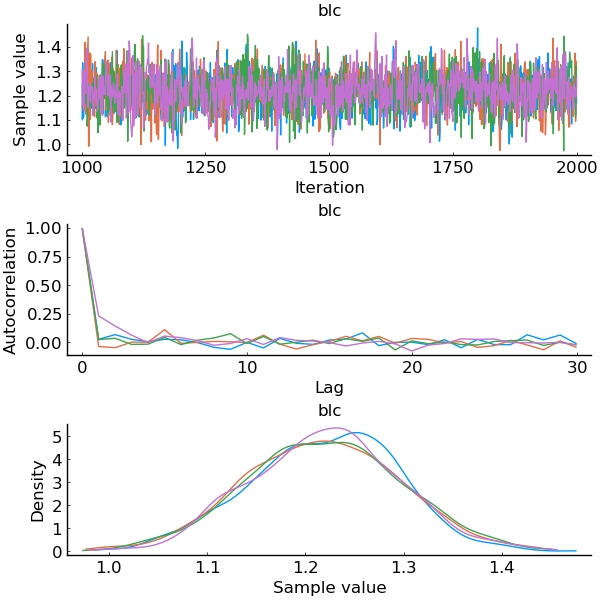

In [27]:
pyplot()
ch = group(chain, :blc)
font_size = 12
p1 = plot(ch, xaxis=font(font_size), yaxis=font(font_size), seriestype=(:traceplot),
  grid=false, size=(250,100), titlefont=font(font_size))
p2 = plot(ch, xaxis=font(font_size), yaxis=font(font_size), seriestype=(:autocorplot),
  grid=false, size=(250,100), titlefont=font(font_size))
p3 = plot(ch, xaxis=font(font_size), yaxis=font(font_size), seriestype=(:mixeddensity),
  grid=false, size=(250,100), titlefont=font(font_size))
pcτ = plot(p1, p2, p3, layout=(3,1), size=(600,600))

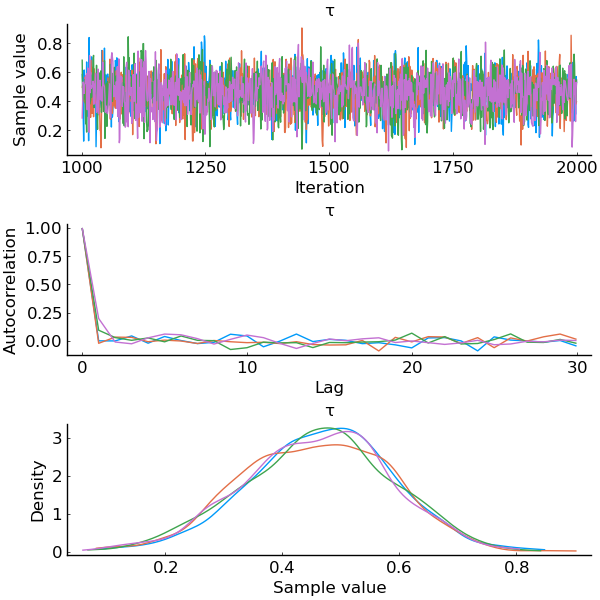

In [28]:
ch = group(chain, :τ)
p1 = plot(ch, xaxis=font(font_size), yaxis=font(font_size), seriestype=(:traceplot),
  grid=false, size=(250,100), titlefont=font(font_size))
p2 = plot(ch, xaxis=font(font_size), yaxis=font(font_size), seriestype=(:autocorplot),
  grid=false, size=(250,100), titlefont=font(font_size))
p3 = plot(ch, xaxis=font(font_size), yaxis=font(font_size), seriestype=(:mixeddensity),
  grid=false, size=(250,100), titlefont=font(font_size))
pcτ = plot(p1, p2, p3, layout=(3,1), size=(600,600))

### Posterior Predictive Distribution

The code block below plots the posterior predictive distributions for correct rts and incorrect rts. As expected, the density for incorrect rts is lower than correct rts, which reflects the fact that incorrect responses are less probable.  

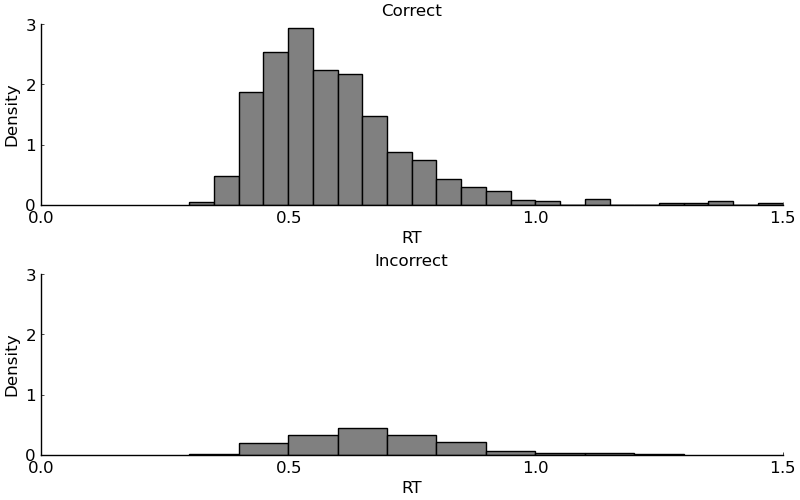

In [29]:
preds = posterior_predictive(x -> simulate(parms; x...), chain, 1000)
correct = filter(x-> x.resp == 1, preds)
rts = map(x->x.rt, correct)
p_correct = mean(x->x.resp == 1, preds)
correct_dist = histogram(rts, xlabel="RT", ylabel="Density", xaxis=font(font_size), yaxis=font(font_size),
    grid=false, norm=true, color=:grey, leg=false, size=(600,300), title="Correct", titlefont=font(font_size),
    xlims=(0,1.5))
correct_dist[1][1][:y] *= p_correct

incorrect = filter(x-> x.resp == 2, preds)
rts = map(x->x.rt, incorrect)
incorrect_dist = histogram(rts, xlabel="RT", ylabel="Density", xaxis=font(font_size), yaxis=font(font_size),
    grid=false, norm=true, color=:grey, leg=false, size=(600,300), title="Incorrect", titlefont=font(font_size),
    xlims=(0,1.5))
incorrect_dist[1][1][:y] *= (1 - p_correct)
plot(correct_dist, incorrect_dist, layout=(2,1), ylims=(0,3), size=(800, 500))